### Cats vs Dogs full

In [10]:
# key file upload / up 파일 이름을 막아둠.
from google.colab import files
up = files.upload()

Saving kaggle.json to kaggle.json


In [11]:
import os, json

with open('kaggle.json') as f:
    kaggle = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle['username']
os.environ['KAGGEL_KEY'] = kaggle['key']

In [12]:
!cp kaggle.json ~/.kaggle/kaggle.json   # cp kaggle.json파일을 지정 dir에 저장

In [13]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

 99% 780M/788M [00:09<00:00, 109MB/s] 
100% 788M/788M [00:09<00:00, 85.0MB/s]


In [14]:
!unzip microsoft-catsvsdogs-dataset.zip > filenames

In [15]:
cat_dir = 'PetImages/Cat'
os.unlink(f'{cat_dir}/Thumbs.db')       # 압축 해제시 생성된 임시파일 삭제
cat_list = os.listdir(cat_dir)
len(cat_list)


12500

In [16]:
dog_dir = 'PetImages/Dog'
os.unlink(f'{dog_dir}/Thumbs.db')       # 압축 해제시 생성된 임시파일 삭제
dog_list = os.listdir(dog_dir)
len(dog_list)

12500

- 이미지 파일 에러 찾기

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
from PIL import Image
from glob import glob

In [19]:
cat_list[:5]

['11867.jpg', '9234.jpg', '2025.jpg', '11224.jpg', '7258.jpg']

In [20]:
for fname in cat_list:
    try:
        img = Image.open(f'PetImages/Cat/{fname}')
    except:
        print(fname)

666.jpg


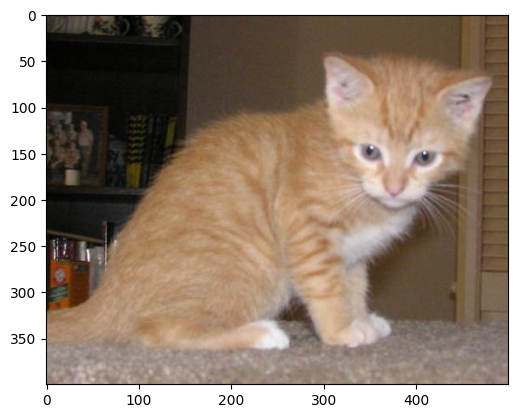

In [21]:
import matplotlib.pyplot as plt
plt.imshow(img);

In [22]:
for fname in glob(f'{dog_dir}/*'):
    try:
        img = Image.open(fname)
    except:
        print(fname)

PetImages/Dog/11702.jpg


- train data:0.jpg ~ 7999.jpg (8,000개)
- valid data:8000.jpg ~ 9999.jpg (2,000개)
- test data: 10000.jpg ~ 12499.jpg (2,500개)

In [23]:
!cp PetImages/Cat/9999.jpg PetImages/Cat/666.jpg
!cp PetImages/Dog/9999.jpg PetImages/Dog/11702.jpg

In [24]:
!mkdir PetImages/Test PetImages/Valid
!mkdir PetImages/Test/Cats PetImages/Test/Dogs
!mkdir PetImages/Valid/Cats PetImages/Valid/Dogs

In [25]:
# mv : move, 8??? 8천번대
!mv PetImages/Cat/8???.* PetImages/Valid/Cats
!mv PetImages/Dog/8???.* PetImages/Valid/Dogs
!mv PetImages/Cat/9???.* PetImages/Valid/Cats
!mv PetImages/Dog/9???.* PetImages/Valid/Dogs

In [26]:
!mv PetImages/Cat/1????.* PetImages/Test/Cats
!mv PetImages/Dog/1????.* PetImages/Test/Dogs

In [27]:
!mkdir PetImages/Train
!mv PetImages/Cat PetImages/Train/Cats
!mv PetImages/Dog PetImages/Train/Dogs

- 모델 구성

In [28]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [29]:
model = Sequential([
    # 이미지를 150x150의 크기로 변환해주는 무언가가 필요하다
    Conv2D(16, (3,3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

In [30]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

model_path = 'best-cats-and-dogs.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=5)

- 파일에서 이미지 데이터를 읽어서 학습시키는 방법

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
valid_datagen = ImageDataGenerator(rescale=1/255.)


In [32]:
train_dir = 'PetImages/Train'
test_dir = 'PetImages/Test'
validation_dir = 'PetImages/Valid'

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

test_generator = test_datagen.flow_from_directory(
    test_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

valid_generator = valid_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

Found 16000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


- 모델 학습

In [33]:
hist = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    steps_per_epoch=800, # batch_size(20) x steps_per_epoch(800) = 16000, 트레인 데이터가 16000개
    validation_steps=200, # batch_size(20) x validation_steps(200) = 4000, 검증데이터가 4000개
    callbacks=[mc, es]
)

Epoch 1/100
799/800 [============================>.] - ETA: 0s - loss: 0.6231 - accuracy: 0.6479
Epoch 1: val_loss improved from inf to 0.52329, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 57s 57ms/step - loss: 0.6231 - accuracy: 0.6479 - val_loss: 0.5233 - val_accuracy: 0.7462
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.7486
Epoch 2: val_loss improved from 0.52329 to 0.46409, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 50s 62ms/step - loss: 0.5170 - accuracy: 0.7486 - val_loss: 0.4641 - val_accuracy: 0.7807
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.4415 - accuracy: 0.7965
Epoch 3: val_loss improved from 0.46409 to 0.41277, saving model to best-cats-and-dogs.h5
800/800 [==============================] - 40s 49ms/step - loss: 0.4415 - accuracy: 0.7965 - val_loss: 0.4128 - val_accuracy: 0.8058
Epoch 4/100
800/800 [=======================

In [34]:
best_model = load_model(model_path)
best_model.evaluate(test_generator)

250/250 [==============================] - 9s 34ms/step - loss: 0.4051 - accuracy: 0.8106


[0.4050690531730652, 0.8105999827384949]

- 테스트 이미지 분류

In [35]:
from google.colab import files

up2 = files.upload()

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.png to cat3.png
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg


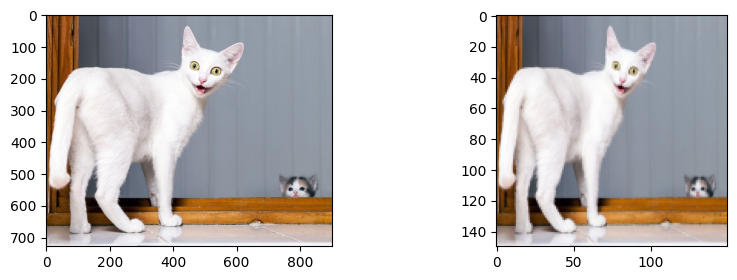

In [36]:
import cv2
img = cv2.imread('cat2.jpg')[:,:,::-1]
img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

In [37]:
best_model.predict(img2.reshape(-1,150,150,3))

1/1 [==============================] - 0s 305ms/step


array([[0.]], dtype=float32)

In [38]:
for fname in up2.keys():
    img = cv2.imread(fname)[:,:,::-1]
    img2 = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    classes = best_model.predict(img2.reshape(-1,150,150,3), verbose=0)
    print(f"{classes[0,0]:.4f} {fname} is {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0000 cat1.jpg is cat
0.0000 cat2.jpg is cat
1.0000 cat3.png is dog
1.0000 dog1.jpg is dog
1.0000 dog2.jpg is dog
1.0000 dog3.jpg is dog


In [39]:
classes[0,0]

1.0